# Classificação de Estágios da Doença de Alzheimer

In [8]:
import zipfile
import os

# arquivo .zip
zip_file = "data.zip"

# Extraia o arquivo
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/data")
    #/data/Alzheimer_MRI_4_classes_dataset

## HistGradientBoostingClassifier

HistGradientBoostingClassifier é um classificador da biblioteca skLearn, sendo uma das suas implementações de árvores com gradiente reforçado.
Esse classificador usa uma estrutura de dados chamada histograma, onde as amostras são ordenadas implicitamente. A construção de um histograma tem uma
complexidade O(n) [1], então o procedimento de divisão de nós tem uma
complexidade O(n_features x n).

O modelo foi escolhido por suportar classificação de múltiplas classes e por ter pontuação de teste e velocidade de treinamento, de forma geral, melhores quando comparados a outros classificadores como o RandomForest [2].

### Bibliotecas

In [9]:
import os
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, log_loss, cohen_kappa_score, hamming_loss, jaccard_score, matthews_corrcoef
from sklearn.decomposition import PCA

### Variáveis iniciais

In [10]:
# Valor fixo de seed para reprodutibilidade
random_seed = 42

# Pasta do dataset
dataset_folder = "../data/Alzheimer_MRI_4_classes_dataset"
folders = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Número máximo de imagens a serem carregadas
max_images_per_class = 100

### Random Seed

In [11]:
random.seed(random_seed)
np.random.seed(random_seed)

### Carregar dados

In [12]:
# Função para carregar e pré-processar as imagens
def load_images(dataset_folder, folders, image_size=(128, 128), max_images_per_class=100):
    images = []
    labels = []
    for folder in folders:
        folder_path = os.path.join(dataset_folder, folder)
        if os.path.exists(folder_path):
            count = 0
            for img_name in os.listdir(folder_path):
                if count >= max_images_per_class:
                    break
                img_path = os.path.join(folder_path, img_name)
                image = Image.open(img_path).convert("RGB")
                image = image.resize(image_size)
                images.append(np.array(image).flatten())
                labels.append(folder)
                count += 1
    return np.array(images), np.array(labels)

### Dividir em treino e teste

In [13]:
# Carregar as imagens e os rótulos
X, y = load_images(dataset_folder, folders, max_images_per_class=max_images_per_class)


# Codificar os rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=56)

### Treinar o modelo

In [14]:
# Criando o classificador escolhido
clf = HistGradientBoostingClassifier(random_state=88)

# Treinando o modelo
clf.fit(X_train, y_train)



HistGradientBoostingClassifier(random_state=88)

### Predizer utilizando o modelo treinado

In [15]:
# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [16]:
# Acurácia
print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.6575342465753424


In [17]:
print("Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Relatório de classificação:
                  precision    recall  f1-score   support

    MildDemented       0.75      0.72      0.73        25
ModerateDemented       0.86      0.86      0.86        14
     NonDemented       0.58      0.61      0.59        18
VeryMildDemented       0.44      0.44      0.44        16

        accuracy                           0.66        73
       macro avg       0.66      0.66      0.66        73
    weighted avg       0.66      0.66      0.66        73



## Alterações e ajustes de hiperparâmetros

Como a acurácia e demais métricas do classificador indicam um resultado não muito satisfatório, foram realizados testes alterando alguns dos hiperparâmetros do classificador, avaliando para isso as características específicas do dataset utilizado.

**1. Estratificação:** Na função responsável por dividir os dados entre treino e teste, foi utilizado o hiperparâmetro stratify=y para garantir que os  conjuntos de treinamento e teste tenham aproximadamente a mesma proporção de representantes de cada classe.

In [18]:
from collections import Counter
print(Counter(y_train))
# classe 1 desbalanceada quando comparada às demais

Counter({3: 84, 2: 82, 0: 75, 1: 50})


In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=56)

clf = HistGradientBoostingClassifier(random_state=88)

# Treinando o modelo
clf.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Acurácia
print("Acurácia:", accuracy_score(y_test, y_pred))


Acurácia: 0.726027397260274


Este ajuste fez com a acurácia aumentasse de 65.7% para 72.6%

**2. Redução de dimensionalidade:**

In [20]:
# Tamanho do conjunto de treinamento
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Tamanho do conjunto de teste
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (291, 49152)
y_train shape: (291,)
X_test shape: (73, 49152)
y_test shape: (73,)


Como observado, o tamanho das amostras é muito pequeno quando comparado à quantidade de features consideradas. Além disso, o tempo para execução ultrapassou 8 minutos para as simulações feitas no ambiente do Colab, indicando alto custo computacional do modelo utilzado na classificação. Apesar do HistGradientBoostingClassifier conseguir trabalhar com múltiplas features e não exigir, de forma geral, a aplicação de redução de dimensionalidade, foi realizado a seleção das principais features usando PCA para evitar o uso de uma quantidade excessiva de features.

In [21]:
pca = PCA(n_components=0.999)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Dimensão original:", X_train.shape)
print("Dimensão reduzida:", X_train_pca.shape)

# Treinando o modelo com os dados reduzidos
clf_pca = HistGradientBoostingClassifier(random_state=88)
clf_pca.fit(X_train_pca, y_train)

# Previsões no conjunto de teste
y_pred_pca = clf_pca.predict(X_test_pca)
y_pred_proba_pca = clf_pca.predict_proba(X_test_pca)

# Avaliando a acurácia
print("Acurácia:", accuracy_score(y_test, y_pred_pca))

Dimensão original: (291, 49152)
Dimensão reduzida: (291, 264)
Acurácia: 0.7123287671232876


A redução de dimensionalidade, mesmo mantendo 0.999 de variância, diminuiu a acurácia do modelo. No entanto, vale observar que a acurácia diminuiu menos de 1%, enquanto o tempo de execução melhorou mais de 97%, o que pode ser um critério considerado a depender dos recursos computacionais disponíveis. Visando manter o modelo com o melhor resultado possível, foi mantido os parâmetros com maior tempo de execução e melhores métricas para análises posteriores e comparação com demais modelos testados no projeto.

**3. Critério de parada:** Visando reduzir a chance de overfitting, foi usado um limite de iterações realizadas pelo modelo, além de alguns ajustes na taxa de aprendizado e a marcação de early_Stopping como True.

### Métricas

In [23]:
clf_stop = HistGradientBoostingClassifier(
    max_iter=300,
    learning_rate=0.12,
    max_depth=15,
    min_samples_leaf=10,
    l2_regularization=1.0,
    early_stopping=True,
    validation_fraction=0.15,
    random_state=88
)
clf_stop.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_stop = clf_stop.predict(X_test)
y_pred_proba_stop = clf_stop.predict_proba(X_test)


In [24]:
# Avaliando a acurácia
print("Acurácia:", accuracy_score(y_test, y_pred_stop))

Acurácia: 0.589041095890411


Todos as combinações de parâmetros na função testados resultaram em métricas piores para o modelo. Desta forma, foram mantidos os valores padrão da função.

De todos os ajustes testados, apenas a inclusão do parâmetro stratify na separação dos conjuntos de treino e teste será considerado.

In [25]:
# Avaliando a acurácia
print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.726027397260274


In [26]:
# Relatório de classificação

print("Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Relatório de classificação:
                  precision    recall  f1-score   support

    MildDemented       0.71      0.75      0.73        20
ModerateDemented       1.00      1.00      1.00        13
     NonDemented       0.64      0.70      0.67        20
VeryMildDemented       0.65      0.55      0.59        20

        accuracy                           0.73        73
       macro avg       0.75      0.75      0.75        73
    weighted avg       0.73      0.73      0.72        73



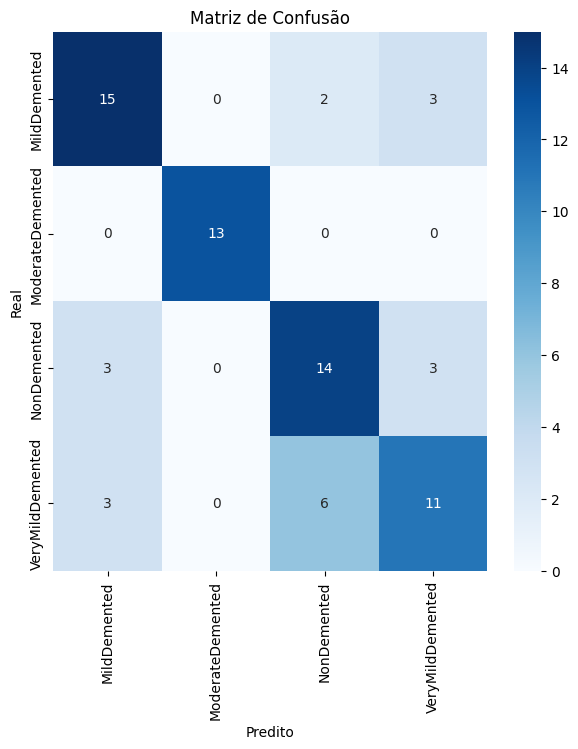

In [27]:
# Matriz de confusão

cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão usando Seaborn com a paleta Set2
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [28]:
# Área sobre a curva ou AUC para cada classe

y_test_binarized = label_binarize(y_test, classes=np.arange(len(folders)))
auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print("AUC:", auc)

AUC: 0.9023584905660378


In [29]:
# Log Loss (Logarithmic Loss)
# Mede a incerteza das previsões. Penaliza previsões incorretas com alta confiança mais severamente do que previsões incorretas com baixa confiança.

log_loss_value = log_loss(y_test, y_pred_proba)
print("Log Loss:", log_loss_value)

Log Loss: 0.9513104975601648


In [30]:
# Cohen's Kappa
# Mede a concordância entre as previsões do modelo e os rótulos verdadeiros, ajustando para a concordância que ocorre por acaso.

kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.6313131313131313


In [31]:
# Hamming Loss
# Mede a fração de rótulos incorretamente previstos. É útil para problemas multilabel.

hamming = hamming_loss(y_test, y_pred)
print("Hamming Loss:", hamming)

Hamming Loss: 0.273972602739726


In [32]:
# Jaccard Index
# Mede a similaridade entre os conjuntos de rótulos previstos e os rótulos verdadeiros.

jaccard = jaccard_score(y_test, y_pred, average='macro')
print("Jaccard Index:", jaccard)

Jaccard Index: 0.6249999999999999


In [33]:
# Matthews Correlation Coefficient (MCC)
# Considera todos os elementos da matriz de confusão e é uma métrica equilibrada que pode ser usada mesmo se as classes tiverem tamanhos muito diferentes.

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.6324320565914313


## Referências

[1] https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

[2] https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_hist_grad_boosting_comparison.html#sphx-glr-auto-examples-ensemble-plot-forest-hist-grad-boosting-comparison-py
